# Initializations


In [1]:
import tensorflow
import numpy
import tensorflow.keras as tfk
import tensorflow as tf
import tensorflow.keras.backend as K

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import math
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
from sklearn.utils import shuffle
import gc

In [2]:
img_size = 17
kernel_size=(img_size,img_size)
num_channels_s = 103
num_channels_t = 72
num_classes=7
latent_space_dim = 25
beta=0.01
alpha=0.00001
LR_loss_factor=0.009
the_lambda=0.001

In [3]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(




**Database:**
RPaviaU-DPaviaC



In [4]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My\ Drive/GANHDA
#%ls

/content/drive/My Drive/GANHDA


In [6]:
# Read the database
import scipy.io
Pavia = scipy.io.loadmat('DataCube-RPaviaU-DPaviaC.mat')
source_data=Pavia['DataCube1']  #RPaviaU
target_data=Pavia['DataCube2']  #DPaviaC
source_gt=Pavia['gt1']  #RPaviaU
target_gt=Pavia['gt2']  #DPaviaC
del Pavia
gc.collect()

0

In [7]:
# Normalize Database
from sklearn import preprocessing
import numpy as np

min_max_scaler = preprocessing.MinMaxScaler()
ascolumns_botswana = target_data.reshape(-1, num_channels_t)
t_botswana = min_max_scaler.fit_transform(ascolumns_botswana)
target_data = t_botswana.reshape(target_data.shape)


min_max_scaler = preprocessing.MinMaxScaler()
ascolumns_botswana = source_data.reshape(-1, num_channels_s)
t_botswana = min_max_scaler.fit_transform(ascolumns_botswana)
source_data = t_botswana.reshape(source_data.shape)


del ascolumns_botswana
del t_botswana
gc.collect()

0

In [8]:
# Zero Padding

target_data=np.pad(target_data, ((8,8),(8,8),(0,0)), 'constant', constant_values= 0)
target_gt=np.pad(target_gt, ((8,8),(8,8)), 'constant', constant_values= 0)

source_data=np.pad(source_data, ((8,8),(8,8),(0,0)), 'constant', constant_values= 0)
source_gt=np.pad(source_gt, ((8,8),(8,8)), 'constant', constant_values= 0)

gc.collect()

0

**Common Labels:**

1- 'Trees'

2- 'Asphalt'

3- 'Bitumen'

4- 'Shadow'

5- 'Brick'

6- 'Meadow'

7- 'Soil'



In [9]:
# Patch IDs

source_ID=np.where(source_gt!=0)
source_ID_gt=source_gt[source_ID[0],source_ID[1]]
source_ID_gt=source_ID_gt-1

target_ID=np.where(target_gt!=0)
target_ID_gt=target_gt[target_ID[0],target_ID[1]]
target_ID_gt=target_ID_gt-1




In [10]:
# Shuffle Dataset

from sklearn.utils import shuffle
source_ID, source_ID_gt = shuffle(numpy.transpose(source_ID), source_ID_gt, random_state=42)
target_ID, target_ID_gt = shuffle(numpy.transpose(target_ID), target_ID_gt, random_state=42)



In [11]:
# Stratified Validation/Train Splitting:

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
stratSplit.get_n_splits(source_ID, source_ID_gt)
for train_index, test_index in stratSplit.split(source_ID, source_ID_gt):
  print("Source TRAIN:", train_index, "Source Validation:", test_index)
  source_trainPatches_ID, source_testPatches_ID = source_ID[train_index], source_ID[test_index]
  source_trainPatches_ID_gt, source_testPatches_ID_gt = source_ID_gt[train_index], source_ID_gt[test_index]



Source TRAIN: [33835 32452 23373 ... 35881 18815  8260] Source Validation: [31203  3679 12029 ... 26972 30560  5902]


In [12]:
# Select only 5 samples per class from the target set for training
train_5indices = []
for i in range(len(np.unique(target_ID_gt))):
    indices = np.where(target_ID_gt == i)[0]
    indices = np.random.choice(indices, size=5, replace=False)
    train_5indices += indices.tolist()

target_5trainPatches_ID = target_ID[train_5indices]
target_5trainPatches_ID_gt = target_ID_gt[train_5indices]


In [13]:
# Replicate

n_replications=int(len(source_testPatches_ID_gt)/(5*num_classes))+1
target_5valtempPatches_ID_gt = np.repeat(target_5trainPatches_ID_gt[:], n_replications, axis=0)
target_5valtempPatches_ID = np.repeat(target_5trainPatches_ID[:], n_replications, axis=0)

n_replications=int(len(source_trainPatches_ID_gt)/(5*num_classes))+1
target_5trainPatches_ID_gt = np.repeat(target_5trainPatches_ID_gt[:], n_replications, axis=0)
target_5trainPatches_ID = np.repeat(target_5trainPatches_ID[:], n_replications, axis=0)


In [14]:
#shuffle
from sklearn.utils import shuffle

target_5trainPatches_ID, target_5trainPatches_ID_gt = shuffle(target_5trainPatches_ID, target_5trainPatches_ID_gt, random_state=42)


target_5valtempPatches_ID, target_5valtempPatches_ID_gt = shuffle(target_5valtempPatches_ID, target_5valtempPatches_ID_gt, random_state=42)


In [15]:
# Create dictionary for labels
source_trainPatches_gt_dict=dict()
for i,labelvalue in enumerate(source_trainPatches_ID_gt):
  source_trainPatches_gt_dict[source_trainPatches_ID[i][0],source_trainPatches_ID[i][1]]=labelvalue


source_testPatches_gt_dict=dict()
for i,labelvalue in enumerate(source_testPatches_ID_gt):
  source_testPatches_gt_dict[source_testPatches_ID[i][0],source_testPatches_ID[i][1]]=labelvalue


target_5trainPatches_gt_dict=dict()
for i,labelvalue in enumerate(target_5trainPatches_ID_gt):
  target_5trainPatches_gt_dict[target_5trainPatches_ID[i][0],target_5trainPatches_ID[i][1]]=labelvalue


target_5valtempPatches_gt_dict=dict()
for i,labelvalue in enumerate(target_5valtempPatches_ID_gt):
  target_5valtempPatches_gt_dict[target_5valtempPatches_ID[i][0],target_5valtempPatches_ID[i][1]]=labelvalue

target_gt_dict=dict()
for i,labelvalue in enumerate(target_ID_gt):
  target_gt_dict[target_ID[i][0],target_ID[i][1]]=labelvalue


source_gt_dict=dict()
for i,labelvalue in enumerate(source_ID_gt):
  source_gt_dict[source_ID[i][0],source_ID[i][1]]=labelvalue

**Set the random seed for Python, Numpy and Tensorflow**

In [16]:
from numpy.random import seed
import random
seed(123)
PYTHONHASHSEED=124
random.seed(125)
tensorflow.random.set_seed(126)

**The only conv layer:**








In [17]:
# The only conv layer _t
It = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels_t),  name="target_input")
conv2d_per_channel_t = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(img_size,img_size), strides=1, name="conv2d_per_channel_t")

x_t=[]
for i in range(num_channels_t):
  temp_t=It[:,:,:,i]
  temp2t=tensorflow.keras.layers.Reshape((temp_t.shape[1], temp_t.shape[2], 1))(temp_t)
  temp3t=conv2d_per_channel_t(temp2t)
  x_t.append(temp3t)

x_t = tensorflow.keras.layers.Concatenate(axis=3)(x_t)
x_t=tensorflow.keras.layers.Reshape([num_channels_t])(x_t)

x_t= tensorflow.keras.layers.LayerNormalization(axis=1)(x_t)
x_t=tensorflow.keras.activations.sigmoid(x_t)



conv_model_t = tensorflow.keras.models.Model(It, x_t, name="conv_model_t")

# summarize  model
conv_model_t.summary()





Model: "conv_model_t"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 target_input (InputLayer)   [(None, 17, 17, 72)]         0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 17)               0         ['target_input[0][0]']        
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 17, 17)               0         ['target_input[0][0]']        
  (SlicingOpLambda)                                                                               
                                                                                       

In [18]:
# The only conv layer _s
Is = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels_s),  name="source_input")
conv2d_per_channel_s = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(img_size,img_size), strides=1, name="conv2d_per_channel_s")

x_s=[]
for i in range(num_channels_s):
  temp_s=Is[:,:,:,i]
  temp2s=tensorflow.keras.layers.Reshape((temp_s.shape[1], temp_s.shape[2], 1))(temp_s)
  temp3s=conv2d_per_channel_s(temp2s)
  x_s.append(temp3s)

x_s = tensorflow.keras.layers.Concatenate(axis=3)(x_s)
x_s=tensorflow.keras.layers.Reshape([num_channels_s])(x_s)

x_s= tensorflow.keras.layers.LayerNormalization(axis=1)(x_s)
x_s=tensorflow.keras.activations.sigmoid(x_s)



conv_model_s = tensorflow.keras.models.Model(Is, x_s, name="conv_model_s")

# summarize  model
conv_model_s.summary()



Model: "conv_model_s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 source_input (InputLayer)   [(None, 17, 17, 103)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_7  (None, 17, 17)               0         ['source_input[0][0]']        
 2 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_7  (None, 17, 17)               0         ['source_input[0][0]']        
 3 (SlicingOpLambda)                                                                              
                                                                                       

**Encoder:**

Model: "encoder_final_model_s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_s (InputLaye  [(None, 103)]                0         []                            
 r)                                                                                               
                                                                                                  
 encoder_dense1s (Dense)     (None, 70)                   7280      ['encoder_input_s[0][0]']     
                                                                                                  
 layer_normalization_2 (Lay  (None, 70)                   140       ['encoder_dense1s[0][0]']     
 erNormalization)                                                                                 
                                                                              

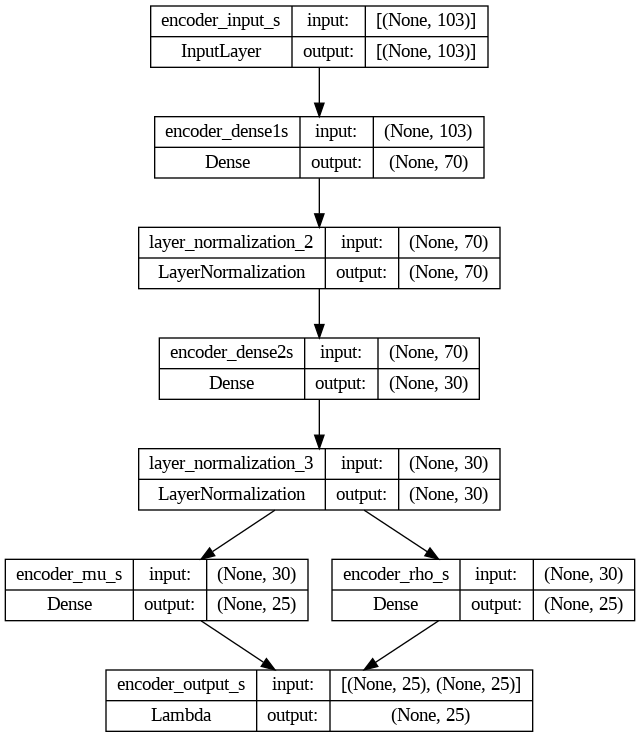

In [19]:
# Encoder_s
e_xs = tensorflow.keras.layers.Input(shape=(num_channels_s), name="encoder_input_s")


encoder_dense1s = tensorflow.keras.layers.Dense(units=70,activation='tanh', name="encoder_dense1s")(e_xs)
encoder_dense1s=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense1s)
encoder_dense2s = tensorflow.keras.layers.Dense(units=30,activation='tanh', name="encoder_dense2s")(encoder_dense1s)
encoder_dense2s=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense2s)

encoder_mu_s = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu_s")(encoder_dense2s)
encoder_rho_s = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_rho_s")(encoder_dense2s)


def sampling_z_only(mu_rho):
        mu,rho=mu_rho
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tensorflow.random.normal(shape=(latent_space_dim,))
        return z_sample



encoder_output_s = tensorflow.keras.layers.Lambda(sampling_z_only, name="encoder_output_s")([encoder_mu_s, encoder_rho_s])


encoder_mu_rho_model_s = tensorflow.keras.models.Model(e_xs, (encoder_mu_s,encoder_rho_s), name="encoder_mu_rho_model_s")
encoder_final_model_s = tensorflow.keras.models.Model(e_xs, encoder_output_s, name="encoder_final_model_s")



# summarize  model
encoder_final_model_s.summary()
# plot  model
plot_model(encoder_final_model_s, to_file='encoder_plot_s.png', show_shapes=True, show_layer_names=True)

Model: "encoder_final_model_t"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_t (InputLaye  [(None, 72)]                 0         []                            
 r)                                                                                               
                                                                                                  
 encoder_dense1t (Dense)     (None, 70)                   5110      ['encoder_input_t[0][0]']     
                                                                                                  
 layer_normalization_4 (Lay  (None, 70)                   140       ['encoder_dense1t[0][0]']     
 erNormalization)                                                                                 
                                                                              

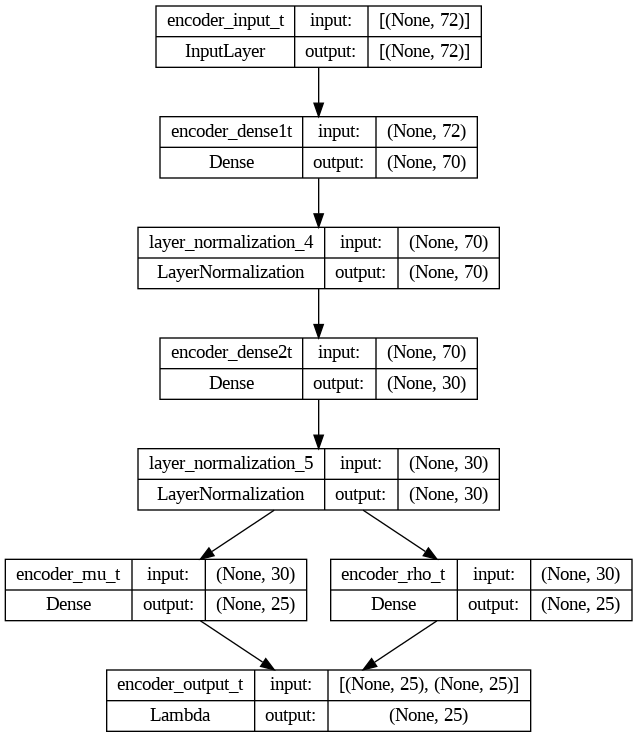

In [20]:
# Encoder_t
e_xt = tensorflow.keras.layers.Input(shape=(num_channels_t), name="encoder_input_t")


encoder_dense1t = tensorflow.keras.layers.Dense(units=70,activation='tanh', name="encoder_dense1t")(e_xt)
encoder_dense1t=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense1t)
encoder_dense2t = tensorflow.keras.layers.Dense(units=30,activation='tanh', name="encoder_dense2t")(encoder_dense1t)
encoder_dense2t=tensorflow.keras.layers.LayerNormalization(axis=1)(encoder_dense2t)

encoder_mu_t = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu_t")(encoder_dense2t)
encoder_rho_t = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_rho_t")(encoder_dense2t)


def sampling_z_only(mu_rho):
        mu,rho=mu_rho
        sd=tensorflow.keras.backend.exp(rho/2);
        z_sample = mu + sd * tensorflow.random.normal(shape=(latent_space_dim,))
        return z_sample



encoder_output_t = tensorflow.keras.layers.Lambda(sampling_z_only, name="encoder_output_t")([encoder_mu_t, encoder_rho_t])


encoder_mu_rho_model_t = tensorflow.keras.models.Model(e_xt, (encoder_mu_t,encoder_rho_t), name="encoder_mu_rho_model_t")
encoder_final_model_t = tensorflow.keras.models.Model(e_xt, encoder_output_t, name="encoder_final_model_t")



# summarize  model
encoder_final_model_t.summary()
# plot  model
plot_model(encoder_final_model_t, to_file='encoder_plot_t.png', show_shapes=True, show_layer_names=True)

**Decoder:**

Model: "decoder_model_s"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_s (InputLaye  [(None, 25)]              0         
 r)                                                              
                                                                 
 decoder_dense1s (Dense)     (None, 30)                780       
                                                                 
 layer_normalization_6 (Lay  (None, 30)                60        
 erNormalization)                                                
                                                                 
 decoder_dense2s (Dense)     (None, 70)                2170      
                                                                 
 layer_normalization_7 (Lay  (None, 70)                140       
 erNormalization)                                                
                                                   

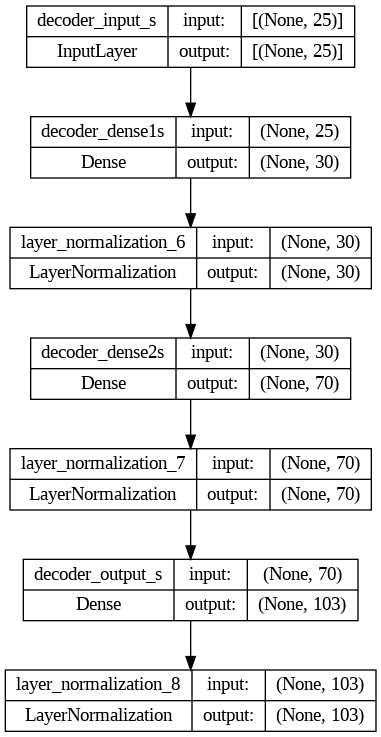

In [21]:
# Decoder_s

#decoder_input = r_s
decoder_input_s = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input_s")

decoder_dense1s = tensorflow.keras.layers.Dense(units=30, activation='tanh', name="decoder_dense1s")(decoder_input_s)
decoder_dense1s=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense1s)
decoder_dense2s = tensorflow.keras.layers.Dense(units=70, activation='tanh', name="decoder_dense2s")(decoder_dense1s)
decoder_dense2s=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense2s)
decoder_output_s = tensorflow.keras.layers.Dense(units=num_channels_s, name="decoder_output_s")(decoder_dense2s)
decoder_output_s= tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_output_s)
decoder_s = tensorflow.keras.models.Model(decoder_input_s, decoder_output_s, name="decoder_model_s")

# summarize  model
decoder_s.summary()
# plot  model
plot_model(decoder_s, to_file='decoder_plot_s.png', show_shapes=True, show_layer_names=True)


Model: "decoder_model_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_t (InputLaye  [(None, 25)]              0         
 r)                                                              
                                                                 
 decoder_dense1t (Dense)     (None, 30)                780       
                                                                 
 layer_normalization_9 (Lay  (None, 30)                60        
 erNormalization)                                                
                                                                 
 decoder_dense2t (Dense)     (None, 70)                2170      
                                                                 
 layer_normalization_10 (La  (None, 70)                140       
 yerNormalization)                                               
                                                   

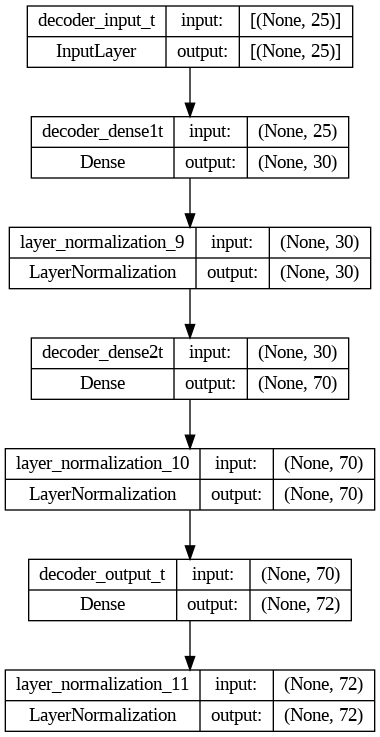

In [22]:
# Decoder_t

#decoder_input = r_t
decoder_input_t = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input_t")

decoder_dense1t = tensorflow.keras.layers.Dense(units=30, activation='tanh', name="decoder_dense1t")(decoder_input_t)
decoder_dense1t=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense1t)
decoder_dense2t = tensorflow.keras.layers.Dense(units=70, activation='tanh', name="decoder_dense2t")(decoder_dense1t)
decoder_dense2t=tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_dense2t)
decoder_output_t = tensorflow.keras.layers.Dense(units=num_channels_t, name="decoder_output_t")(decoder_dense2t)
decoder_output_t= tensorflow.keras.layers.LayerNormalization(axis=1)(decoder_output_t)
decoder_t = tensorflow.keras.models.Model(decoder_input_t, decoder_output_t, name="decoder_model_t")

# summarize  model
decoder_t.summary()
# plot  model
plot_model(decoder_t, to_file='decoder_plot_t.png', show_shapes=True, show_layer_names=True)


**Classifiers:**

Model: "c1_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c1_input (InputLayer)       [(None, 25)]              0         
                                                                 
 c1_output (Dense)           (None, 7)                 182       
                                                                 
Total params: 182 (728.00 Byte)
Trainable params: 182 (728.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


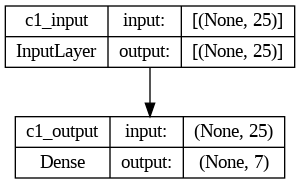

In [23]:
# Classifier1
c1_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="c1_input")
#c1_intermediate1 = tensorflow.keras.layers.Dense(units=50, activation='tanh', kernel_initializer='he_uniform', name="c1_intermediate1")(c1_input)
#c1_intermediate2 = tensorflow.keras.layers.Dense(units=25, activation='tanh', kernel_initializer='he_uniform', name="c1_intermediate2")(c1_intermediate1)
c1_output = tensorflow.keras.layers.Dense(units=num_classes, activation='softmax', name="c1_output")(c1_input)

c1 = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")

# summarize  model
c1.summary()
# plot  model
plot_model(c1, to_file='c1_plot.png', show_shapes=True, show_layer_names=True)

Model: "c2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 c2_input (InputLayer)       [(None, 25)]              0         
                                                                 
 c2_output (Dense)           (None, 7)                 182       
                                                                 
Total params: 182 (728.00 Byte)
Trainable params: 182 (728.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


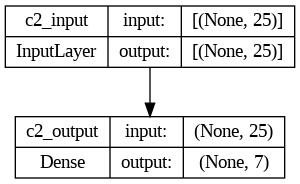

In [24]:
# Classifier2
c2_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="c2_input")
#c2_intermediate1 = tensorflow.keras.layers.Dense(units=50, activation='tanh', kernel_initializer='he_uniform', name="c2_intermediate1")(c2_input)
#c2_intermediate2 = tensorflow.keras.layers.Dense(units=25, activation='tanh', kernel_initializer='he_uniform', name="c2_intermediate2")(c2_intermediate1)
c2_output = tensorflow.keras.layers.Dense(units=num_classes, activation='softmax', name="c2_output")(c2_input)

c2 = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

# summarize  model
c2.summary()
# plot  model
plot_model(c2, to_file='c2_plot.png', show_shapes=True, show_layer_names=True)

**Step 1 Model:**

In [55]:
class step_1_model_class(tfk.Model):

    def __init__(self, dim_z, kl_weight=1, LR_FACTOR=1, name="step_1_model_class", **kwargs):
        super(step_1_model_class, self).__init__(name=name, **kwargs)
        self.dim_x_s = (img_size, img_size, num_channels_s)
        self.dim_x_t = (img_size, img_size, num_channels_t)
        #self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder_s =   tensorflow.keras.models.Model(e_xs, (encoder_mu_s,encoder_rho_s), name="encoder_mu_rho_model_s")
        self.encoder_t =   tensorflow.keras.models.Model(e_xt, (encoder_mu_t,encoder_rho_t), name="encoder_mu_rho_model_t")
        self.decoder_s = tensorflow.keras.models.Model(decoder_input_s, decoder_output_s, name="decoder_model_s")
        self.decoder_t = tensorflow.keras.models.Model(decoder_input_t, decoder_output_t, name="decoder_model_t")
        self.conv_model_s = tensorflow.keras.models.Model(Is, x_s, name="conv_model_s")
        self.conv_model_t = tensorflow.keras.models.Model(It, x_t, name="conv_model_t")
        self.c1_st = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_st = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")
        #self.dp_model = tensorflow.keras.models.Model([dp_input_1,dp_input_2], dp_output, name="dp_model")
        self.kl_weight = kl_weight

        self.conv_model_s.trainable = True
        self.conv_model_t.trainable = True
        self.encoder_s.trainable = True
        self.encoder_t.trainable = True
        self.decoder_s.trainable = True
        self.decoder_t.trainable = True
        self.c1_st.trainable = True
        self.c2_st.trainable = True

    # custom loss function with tf.nn.sigmoid_cross_entropy_with_logits
    def custom_sigmoid_cross_entropy_loss_with_logits(self,x_true, x_recons_logits): # Reconstruction loss In case of Bernoulli distribution assumption
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=-1)

        #return tf.math.reduce_mean(neg_log_likelihood)
        return (neg_log_likelihood)

    def vae_reconstruction_loss(self,y_true, y_predict):    # Reconstruction loss In case of Gaussian distribution assumption
        reconstruction_loss_factor = 1/2
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-tf.sigmoid(y_predict)), axis=-1)
        reconstruction_loss=tf.math.log(reconstruction_loss*2*math.pi)
        return tensorflow.keras.backend.mean(reconstruction_loss_factor * reconstruction_loss)

    def vae_kl_loss(self,encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=-1)
        #return tensorflow.keras.backend.mean(kl_loss)
        return (kl_loss)

    def encode_s(self, x_input):
        mu1,rho1 = self.encoder_s(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1

    def encode_t(self, x_input):
        mu1,rho1 = self.encoder_t(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1




    def call(self, x_input):
        [input_t,ytrue_t],[input_s,ytrue_s]=x_input
        conv_out_t=self.conv_model_t(input_t)
        conv_out_s=self.conv_model_s(input_s)
        z_sample_t, mu_t, rho_t = self.encode_t(conv_out_t)
        z_sample_s, mu_s, rho_s = self.encode_s(conv_out_s)

        w = tf.cast(tf.equal(ytrue_s, ytrue_t), tf.float32)
        diff = z_sample_s - z_sample_t
        # Calculate L2 norm of diff
        norm_of_diff = tf.norm(diff, ord=2, axis=1)
        graph_reg_term=norm_of_diff*w
        graph_reg_term=graph_reg_term/tf.reduce_sum(w)

        norm_s = tf.norm(conv_out_s, axis=1, keepdims=False)
        norm_t = tf.norm(conv_out_t, axis=1, keepdims=False)
        norm_div = tf.divide(norm_s, norm_t)

        x_logits_t = self.decoder_t(z_sample_t)
        x_logits_s = self.decoder_s(z_sample_s)
        z1_t=self.c1_st(z_sample_t)
        z2_t=self.c2_st(z_sample_t)
        z1_s=self.c1_st(z_sample_s)
        z2_s=self.c2_st(z_sample_s)

        # Add Losses:
        self.add_loss(tensorflow.keras.backend.mean(LR_loss_factor*norm_div*self.kl_weight * self.vae_kl_loss(mu_t,rho_t)))
        self.add_loss(tf.math.reduce_mean(LR_loss_factor*norm_div**self.custom_sigmoid_cross_entropy_loss_with_logits(conv_out_t,x_logits_t)))
        self.add_loss(tensorflow.keras.backend.mean(LR_loss_factor*self.kl_weight * self.vae_kl_loss(mu_s,rho_s)))
        self.add_loss(tf.math.reduce_mean(LR_loss_factor*self.custom_sigmoid_cross_entropy_loss_with_logits(conv_out_s,x_logits_s)))
        self.add_loss(tensorflow.keras.backend.mean(LR_loss_factor*the_lambda*graph_reg_term))
        #self.add_loss(LR_loss_factor*self.vae_reconstruction_loss(conv_out,x_logits2))
        return [z1_t, z2_t], [z1_s, z2_s]




In [56]:
Model_step1 = step_1_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_step1.compile(optimizer=tensorflow.keras.optimizers.Adam(),
  loss={'output_1_1':'categorical_crossentropy','output_1_2':'categorical_crossentropy','output_2_1':'categorical_crossentropy','output_2_2':'categorical_crossentropy'},
  metrics=[tf.keras.metrics.CategoricalAccuracy()]
)



**Step 2a Model:**

In [57]:
class step_2a_model_class(tfk.Model):

    def __init__(self, dim_z,euclidean_Weight, name="step_2a_model_class", **kwargs):
        super(step_2a_model_class, self).__init__(name=name, **kwargs)
        self.dim_x_s = (img_size, img_size, num_channels_s)
        self.dim_x_t = (img_size, img_size, num_channels_t)
        self.dim_z = dim_z
        self.euclidean_Weight=euclidean_Weight
        self.encoder_s =   tensorflow.keras.models.Model(e_xs, (encoder_mu_s,encoder_rho_s), name="encoder_mu_rho_model_s")
        self.encoder_t =   tensorflow.keras.models.Model(e_xt, (encoder_mu_t,encoder_rho_t), name="encoder_mu_rho_model_t")
        self.conv_model_s = tensorflow.keras.models.Model(Is, x_s, name="conv_model_s")
        self.conv_model_t = tensorflow.keras.models.Model(It, x_t, name="conv_model_t")
        self.c1_st = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_st = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

        self.conv_model_s.trainable=False
        self.conv_model_t.trainable=False
        self.encoder_s.trainable=False
        self.encoder_t.trainable=False
        self.c1_st.trainable=True
        self.c2_st.trainable=True


    def encode_s(self, x_input):
        mu1,rho1 = self.encoder_s(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1

    def encode_t(self, x_input):
        mu1,rho1 = self.encoder_t(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1




    def call(self, x_input):
        [input_s,input_t,input_5t,ytrue_s,ytrue_5t]=x_input
        conv_out_s=self.conv_model_s(input_s)
        conv_out_t=self.conv_model_t(input_t)
        conv_out_5t=self.conv_model_t(input_5t)
        z_sample_5t, mu_5t, rho_5t = self.encode_t(conv_out_5t)
        z_sample_t, mu_t, rho_t = self.encode_t(conv_out_t)
        z_sample_s, mu_s, rho_s = self.encode_s(conv_out_s)

        w = tf.cast(tf.equal(tf.argmax(ytrue_s, axis=1), tf.argmax(ytrue_5t, axis=1)), tf.float32)
        diff = z_sample_s - z_sample_t
        # Calculate L2 norm of diff
        norm_of_diff = tf.norm(diff, ord=2, axis=1)
        graph_reg_term=norm_of_diff*w
        graph_reg_term=graph_reg_term/tf.reduce_sum(w)

        z1_s=self.c1_st(z_sample_s)
        z2_s=self.c2_st(z_sample_s)
        z1_t=self.c1_st(z_sample_t)
        z2_t=self.c2_st(z_sample_t)
        euclidean_loss=K.sqrt(K.sum(K.square(z1_t - z2_t), axis=-1))

        # Add Losses:
        self.add_loss(-self.euclidean_Weight*tf.math.reduce_mean(euclidean_loss))
        self.add_loss(-self.euclidean_Weight*tensorflow.keras.backend.mean(LR_loss_factor*the_lambda*graph_reg_term))
        return z1_s,z2_s


In [58]:
    Model_step2a = step_2a_model_class(dim_z=latent_space_dim,euclidean_Weight=alpha)
    Model_step2a.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00005),
            loss={'output_1':'categorical_crossentropy','output_2':'categorical_crossentropy'}, metrics=[tf.keras.metrics.CategoricalAccuracy()])


**Step 2b Model:**

In [59]:
class step_2b_model_class(tfk.Model):

    def __init__(self, dim_z, name="step_2b_model_class", **kwargs):
        super(step_2b_model_class, self).__init__(name=name, **kwargs)
        self.dim_x_s = (img_size, img_size, num_channels_s)
        self.dim_x_t = (img_size, img_size, num_channels_t)
        self.dim_z = dim_z
        self.encoder_s =   tensorflow.keras.models.Model(e_xs, (encoder_mu_s,encoder_rho_s), name="encoder_mu_rho_model_s")
        self.encoder_t =   tensorflow.keras.models.Model(e_xt, (encoder_mu_t,encoder_rho_t), name="encoder_mu_rho_model_t")
        self.conv_model_t = tensorflow.keras.models.Model(It, x_t, name="conv_model_t")
        self.conv_model_s = tensorflow.keras.models.Model(Is, x_s, name="conv_model_s")
        self.c1_st = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_st = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")

        self.conv_model_t.trainable=True
        self.conv_model_s.trainable=True
        self.encoder_t.trainable=True
        self.encoder_s.trainable=True
        self.c1_st.trainable=False
        self.c2_st.trainable=False


    def encode_s(self, x_input):
        mu1,rho1 = self.encoder_s(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1

    def encode_t(self, x_input):
        mu1,rho1 = self.encoder_t(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1





    def call(self, x_input):
        [input_t,input_5t,ytrue_5t,input_s,ytrue_s]=x_input
        conv_out_t=self.conv_model_t(input_t)
        conv_out_5t=self.conv_model_t(input_5t)
        conv_out_s=self.conv_model_s(input_s)
        z_sample_t, mu_t, rho_t = self.encode_t(conv_out_t)
        z_sample_5t, mu_5t, rho_5t = self.encode_t(conv_out_5t)
        z_sample_s, mu_s, rho_s = self.encode_s(conv_out_s)

        w = tf.cast(tf.equal(tf.argmax(ytrue_s, axis=1), tf.argmax(ytrue_5t, axis=1)), tf.float32)
        diff = z_sample_s - z_sample_t
        # Calculate L2 norm of diff
        norm_of_diff = tf.norm(diff, ord=2, axis=1)
        graph_reg_term=norm_of_diff*w
        graph_reg_term=graph_reg_term/tf.reduce_sum(w)

        z1_t=self.c1_st(z_sample_t)
        z2_t=self.c2_st(z_sample_t)


        euclidean_loss=K.sqrt(K.sum(K.square(z1_t - z2_t), axis=-1))

        # Add Losses:
        self.add_loss(tf.math.reduce_mean(euclidean_loss))
        self.add_loss(tensorflow.keras.backend.mean(LR_loss_factor*the_lambda*graph_reg_term))
        return None


In [60]:
    Model_step2b = step_2b_model_class(dim_z=latent_space_dim)
    Model_step2b.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00005))


In [61]:
# Generator Class source

import numpy as np
import keras


class DataGenerator_s(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataname, list_IDs, labels, batch_size=32, dim=(17,17), n_channels_s=103,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels_s = n_channels_s
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataname=dataname

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y, ycat = self.__data_generation(list_IDs_temp)

        return [X, y],[ycat, ycat]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels_s))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]

            # Store class
            y[i] = self.labels[ID[0],ID[1]]

        return X,y, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [62]:
# Generator Class Target

import numpy as np
import keras


class DataGenerator_t(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataname, list_IDs, labels, batch_size=32, dim=(17,17), n_channels_t=72,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels_t = n_channels_t
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dataname=dataname

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y, ycat = self.__data_generation(list_IDs_temp)

        return [X, y],[ycat, ycat]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels_t))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]

            # Store class
            y[i] = self.labels[ID[0],ID[1]]

        return X, y, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [63]:
class DataGenerator_combined(keras.utils.Sequence):
    def __init__(self, generator1, generator2):
        self.generator1 = generator1
        self.generator2 = generator2

    def __len__(self):
        return len(self.generator1)

    def __getitem__(self, index):
        X1, y1 = self.generator1[index]
        X2, y2 = self.generator2[index]
        return [X1, X2], [y1, y2]

# Training

In [ ]:
# Start Training (Step 1):

import numpy as np
import multiprocessing

params_t = {'dim': (17,17),
          'batch_size': 128,
          'n_classes': num_classes,
          'n_channels_t': num_channels_t,
          'shuffle': True}

params_s = {'dim': (17,17),
          'batch_size': 128,
          'n_classes': num_classes,
          'n_channels_s': num_channels_s,
          'shuffle': True}
# Generators
training_generator_t = DataGenerator_t(target_data, target_5trainPatches_ID, target_5trainPatches_gt_dict, **params_t)
training_generator_s = DataGenerator_s(source_data, source_trainPatches_ID, source_trainPatches_gt_dict, **params_s)
training_generator = DataGenerator_combined(training_generator_t,training_generator_s)
validation_generator_s = DataGenerator_s(source_data, source_testPatches_ID, source_testPatches_gt_dict, **params_s)
validation_generator_t = DataGenerator_t(target_data, target_5valtempPatches_ID, target_5valtempPatches_gt_dict, **params_t)
validation_generator = DataGenerator_combined(validation_generator_t,validation_generator_s)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('rpu_best_model1_chkp',save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

#                    validation_data=validation_generator,

Model_step1.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[es,mc],
                    epochs=5000,
                    workers=multiprocessing.cpu_count())



In [65]:
#Load the best saved checkpoint
Model_step1.load_weights('rpu_best_model1_chkp')


**Train Steps 2a & 2b :**

In [66]:
params_t = {'dim': (17,17),
          'batch_size': 128,
          'n_classes': num_classes,
          'n_channels_t': num_channels_t,
          'shuffle': True}

params_s = {'dim': (17,17),
          'batch_size': 128,
          'n_classes': num_classes,
          'n_channels_s': num_channels_s,
          'shuffle': True}



In [67]:
def extract_patches_t(dataname, list_IDs):
  #self.dataname=dataname
  #self.list_IDs=list_IDs
  batch_size = list_IDs.shape[0]
  batch = np.empty((batch_size, img_size,img_size, num_channels_t))
  for i, ID in enumerate(list_IDs):
    # Store sample
    batch[i,] = dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]
  return batch



def extract_patches_s(dataname, list_IDs):
  #self.dataname=dataname
  #self.list_IDs=list_IDs
  batch_size = list_IDs.shape[0]
  batch = np.empty((batch_size, img_size,img_size, num_channels_s))
  for i, ID in enumerate(list_IDs):
    # Store sample
    batch[i,] = dataname[ID[0]-8:ID[0]+9,ID[1]-8:ID[1]+9,:]
  return batch

In [ ]:
# Start Training (Steps 2a & 2b) :

n_epochs=500
n_batch=128 # number of samples in each batch
shuffle_before_each_epoch=True
early_stop_enabled=True
max_patience=40


minimumSampleNumber=min(source_trainPatches_ID_gt.shape[0],target_ID_gt.shape[0])
int_division=int(minimumSampleNumber/n_batch)
remainingSamples=minimumSampleNumber-int_division*n_batch
if(remainingSamples)>0:
  n_parts=int_division+1
else:
  n_parts=int_division

patience_count=0
min_bc=float('inf')
for i in range(n_epochs):
  gc.collect()
  print('\n')

  if(shuffle_before_each_epoch==True):
    source_trainPatches_ID, source_trainPatches_ID_gt = shuffle(source_trainPatches_ID, source_trainPatches_ID_gt, random_state=42)
    target_ID, target_ID_gt = shuffle(target_ID, target_ID_gt, random_state=42)
    target_5trainPatches_ID, target_5trainPatches_ID_gt = shuffle(target_5trainPatches_ID, target_5trainPatches_ID_gt, random_state=42)
  for j in range(n_parts):
    if(j<int_division):
      source_batch=extract_patches_s(source_data, source_trainPatches_ID[j*n_batch:j*n_batch+n_batch])
      target_batch=extract_patches_t(target_data, target_ID[j*n_batch:j*n_batch+n_batch])
      target5_batch=extract_patches_t(target_data, target_5trainPatches_ID[j*n_batch:j*n_batch+n_batch])

      source_batch_gt=source_trainPatches_ID_gt[j*n_batch:j*n_batch+n_batch]
      target5_batch_gt=target_5trainPatches_ID_gt[j*n_batch:j*n_batch+n_batch]
    else:
      source_batch=extract_patches_s(source_data,source_trainPatches_ID[int_division*n_batch:int_division*n_batch+remainingSamples])
      target_batch=extract_patches_t(target_data,target_ID[int_division*n_batch:int_division*n_batch+remainingSamples])
      target5_batch=extract_patches_t(target_data,target_5trainPatches_ID[int_division*n_batch:int_division*n_batch+remainingSamples])

      source_batch_gt=source_trainPatches_ID_gt[int_division*n_batch:int_division*n_batch+remainingSamples]
      target5_batch_gt=target_5trainPatches_ID_gt[int_division*n_batch:int_division*n_batch+remainingSamples]

    source_batch_gt=keras.utils.to_categorical(source_batch_gt, num_classes)
    target5_batch_gt=keras.utils.to_categorical(target5_batch_gt, num_classes)

    if (j==0):
      should_reset_metrics=True
    else:
      should_reset_metrics=False

    lossb,lossb1,lossb2,acc1,acc2=Model_step2a.train_on_batch([source_batch,target_batch,target5_batch,source_batch_gt,target5_batch_gt], [source_batch_gt,source_batch_gt],reset_metrics=should_reset_metrics)

    lossc=Model_step2b.train_on_batch([target_batch,target5_batch,target5_batch_gt,source_batch,source_batch_gt],None,reset_metrics=should_reset_metrics)

    print('\rEpoch '+ str(i+1)+'/'+str(n_epochs)+' Step '+ str(j+1)+ '/'+ str(n_parts)+ ': acc1=', str(acc1)+ ' acc2='+ str(acc2)+' lossb='+str(lossb)+' lossb1='+
          str(lossb1)+' lossb2='+str(lossb2)+' lossc='+str(lossc), end=''),
  #Early stopping:
  if(early_stop_enabled==True):
    #total_lossbc=0.1*lossb+lossc
    total_lossbc=lossc-lossb
    if(total_lossbc<min_bc):
      min_bc=total_lossbc
      patience_count=0
      Model_step1.save_weights('rpu_best_model2_chkp')
      print("\nCheckPoint Saved")
    else:
      patience_count=patience_count+1;
      if (patience_count>=max_patience):
        print("\nEarly Stopping..")
        break


In [ ]:
#Load the best saved checkpoint
Model_step1.load_weights('rpu_best_model2_chkp')

In [ ]:
# Save Final Weights
Model_step1.save_weights('RPaviaU-DPaviaC_final_weights')

**End of Training Phase.**
# Evaluations:

In [39]:
# Loading Final Saved Weights
# If no saved weight is availabe, already learned weights will be downloaded from github.

import os

if(os.path.isfile('RPaviaU-DPaviaC_final_weights.index')==False):
  !wget https://github.com/amirmah/HSI_GANHDA/raw/main/RPaviaU-DPaviaC_final_weights.index

if(os.path.isfile('RPaviaU-DPaviaC_final_weights.data-00000-of-00001')==False):
  !wget https://github.com/amirmah/HSI_GANHDA/raw/main/RPaviaU-DPaviaC_final_weights.data-00000-of-00001

Model_step1.load_weights('RPaviaU-DPaviaC_final_weights')

In [40]:
params_t = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': num_classes,
          'n_channels_t': num_channels_t,
          'shuffle': True}

params_s = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': num_classes,
          'n_channels_s': num_channels_s,
          'shuffle': True}

In [41]:
# Accuracy, Precision, recall and f1-score
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

params_t = {'dim': (17,17),
            'batch_size': 1,
            'n_classes': num_classes,
            'n_channels_t': num_channels_t,
            'shuffle': False}

params_s = {'dim': (17,17),
            'batch_size': 1,
            'n_classes': num_classes,
            'n_channels_s': num_channels_s,
            'shuffle': False}
target_generator = DataGenerator_t(target_data,target_ID, target_gt_dict, **params_t)
source_generator = DataGenerator_s(source_data,source_ID, source_gt_dict, **params_s)
all_generator = DataGenerator_combined(target_generator,source_generator)

y_pred=Model_step1.predict_generator(generator=all_generator)
y_pred=np.argmax(y_pred[0][0],axis=1)

print(classification_report(target_ID_gt,y_pred,digits=4 ))


<ipython-input-41-eeb722e2ba15>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred=Model_step1.predict_generator(generator=all_generator)


              precision    recall  f1-score   support

           0     0.9721    0.8911    0.9298      2424
           1     0.8266    0.9401    0.8797      1704
           2     0.9256    0.6905    0.7910       685
           3     0.8417    0.8382    0.8399       241
           4     0.9627    0.9347    0.9485      2237
           5     0.8165    0.9353    0.8718      1251
           6     0.8841    0.8997    0.8918      1475

    accuracy                         0.9010     10017
   macro avg     0.8899    0.8757    0.8789     10017
weighted avg     0.9065    0.9010    0.9010     10017



Text(95.72222222222221, 0.5, 'True')

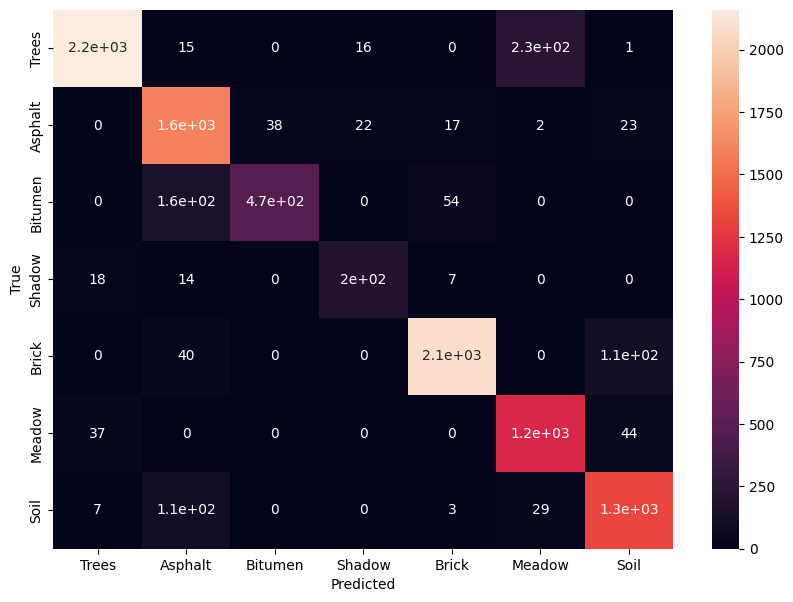

In [42]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

# Get true and predicted labels
y_true = target_ID_gt
y_pred = y_pred

# Calculate confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['Trees', 'Asphalt', 'Bitumen', 'Shadow', 'Brick', 'Meadow', 'Soil']

df_cm = pd.DataFrame(cnf_matrix, index=class_names,
                     columns=class_names)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')


In [43]:
# Average Accuracy
import pandas as pd
accuracies = np.equal(pd.get_dummies(target_ID_gt), pd.get_dummies(y_pred)).mean(axis=0)
aac=accuracies.mean()
print(accuracies)
print("Average Accuracy=",aac)

0    0.967455
1    0.956274
2    0.975042
3    0.992313
4    0.977339
5    0.965658
6    0.967855
dtype: float64
Average Accuracy= 0.9717052439424407


In [44]:
# Cohen Kappa metric

import tensorflow_addons as tfa

#Recompile the model with Cohen Kappa metric added:
Model_step1 = step_1_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_step1.compile(optimizer=tensorflow.keras.optimizers.Adam(),
  loss={'output_1_1':'categorical_crossentropy','output_1_2':'categorical_crossentropy','output_2_1':'categorical_crossentropy','output_2_2':'categorical_crossentropy'},
  metrics=[tf.keras.metrics.CategoricalAccuracy(),tfa.metrics.CohenKappa(num_classes=num_classes)]
)

params_t = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': num_classes,
          'n_channels_t': num_channels_t,
          'shuffle': False}

params_s = {'dim': (17,17),
          'batch_size': 1,
          'n_classes': num_classes,
          'n_channels_s': num_channels_s,
          'shuffle': False}

# Evaluate on Target
target_generator = DataGenerator_t(target_data,target_ID, target_gt_dict, **params_t)
source_generator = DataGenerator_s(source_data,source_ID, source_gt_dict, **params_s)
all_generator = DataGenerator_combined(target_generator,source_generator)
results=Model_step1.evaluate_generator(generator=all_generator)

print(results)
print("\nkappa=",results[6])


<ipython-input-44-da6871122d58>:28: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results=Model_step1.evaluate_generator(generator=all_generator)


[nan, 0.7872716784477234, 0.7875688672065735, 9.33060359954834, 9.325141906738281, 0.9001697301864624, 0.8783846497535706, 0.9002695679664612, 0.8785051703453064, 0.5685334801673889, 0.3056606650352478, 0.5691324472427368, 0.30644023418426514]

kappa= 0.8783846497535706


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


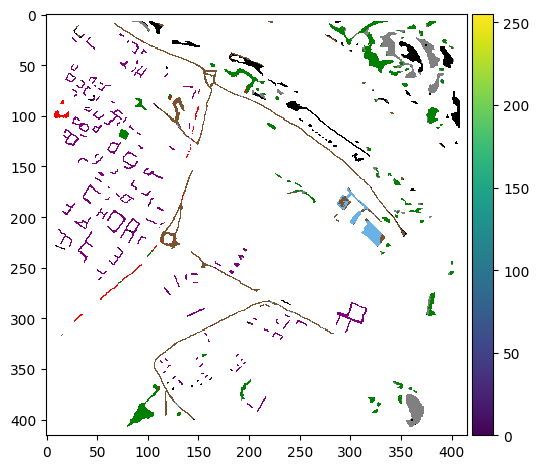

In [45]:
# Final Classification Map

from skimage import io
from skimage import color
from skimage import segmentation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.colors as mc

tp_indexes=target_ID

backgr=np.zeros([416,416])
seg=np.zeros([416,416])
for ii in range(len(tp_indexes)):
  seg[tp_indexes[ii][0],tp_indexes[ii][1]]=y_pred[ii]+1

# Generate automatic colouring from classification labels
io.imshow(color.label2rgb(seg,backgr,bg_color=(255,255,255),colors=('green',np.array(mc.to_rgb('#7a5331')),np.array(mc.to_rgb('#6ab2e6')),'red','purple','grey','black')
,bg_label=0,alpha=1))
plt.show()

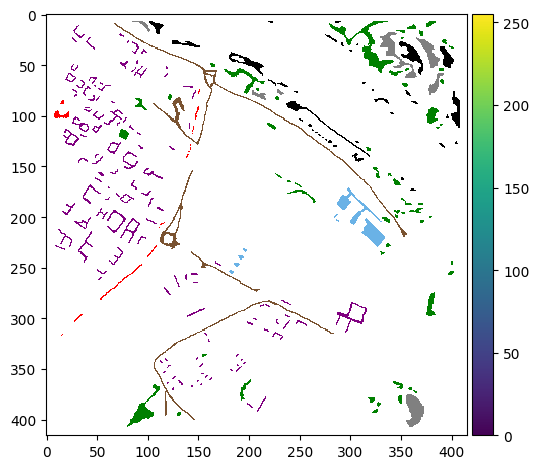

In [46]:
# Ground truth

io.imshow(color.label2rgb(target_gt,np.zeros([416,416]),bg_color=(255,255,255),colors=('green',np.array(mc.to_rgb('#7a5331')),np.array(mc.to_rgb('#6ab2e6')),'red','purple','grey','black')
,bg_label=0,alpha=1))
plt.show()





**Additional Analysis**

In [47]:
# A model to simply output the values of latent layer
class data_vis_model_class(tfk.Model):

    def __init__(self, dim_z, kl_weight=1, LR_FACTOR=1, name="data_vis_model_class", **kwargs):
        super(data_vis_model_class, self).__init__(name=name, **kwargs)
        self.dim_x_s = (img_size, img_size, num_channels_s)
        self.dim_x_t = (img_size, img_size, num_channels_t)
        #self.dim_x = (img_size, img_size, num_channels)
        self.dim_z = dim_z
        self.encoder_s =   tensorflow.keras.models.Model(e_xs, (encoder_mu_s,encoder_rho_s), name="encoder_mu_rho_model_s")
        self.encoder_t =   tensorflow.keras.models.Model(e_xt, (encoder_mu_t,encoder_rho_t), name="encoder_mu_rho_model_t")
        self.decoder_s = tensorflow.keras.models.Model(decoder_input_s, decoder_output_s, name="decoder_model_s")
        self.decoder_t = tensorflow.keras.models.Model(decoder_input_t, decoder_output_t, name="decoder_model_t")
        self.conv_model_s = tensorflow.keras.models.Model(Is, x_s, name="conv_model_s")
        self.conv_model_t = tensorflow.keras.models.Model(It, x_t, name="conv_model_t")
        self.c1_st = tensorflow.keras.models.Model(c1_input, c1_output, name="c1_model")
        self.c2_st = tensorflow.keras.models.Model(c2_input, c2_output, name="c2_model")
        #self.dp_model = tensorflow.keras.models.Model([dp_input_1,dp_input_2], dp_output, name="dp_model")
        self.kl_weight = kl_weight

    # custom loss function with tf.nn.sigmoid_cross_entropy_with_logits
    def custom_sigmoid_cross_entropy_loss_with_logits(self,x_true, x_recons_logits): # Reconstruction loss In case of Bernoulli distribution assumption
        raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
                                            labels=x_true, logits=x_recons_logits)
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=-1)

        #return tf.math.reduce_mean(neg_log_likelihood)
        return (neg_log_likelihood)

    def vae_reconstruction_loss(self,y_true, y_predict):    # Reconstruction loss In case of Gaussian distribution assumption
        reconstruction_loss_factor = 1/2
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-tf.sigmoid(y_predict)), axis=-1)
        reconstruction_loss=tf.math.log(reconstruction_loss*2*math.pi)
        return tensorflow.keras.backend.mean(reconstruction_loss_factor * reconstruction_loss)

    def vae_kl_loss(self,encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=-1)
        #return tensorflow.keras.backend.mean(kl_loss)
        return (kl_loss)

    def encode_s(self, x_input):
        mu1,rho1 = self.encoder_s(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1

    def encode_t(self, x_input):
        mu1,rho1 = self.encoder_t(x_input)
        sd1=tensorflow.keras.backend.exp(rho1/2);
        z_sample1 = mu1 + sd1 * tf.random.normal(shape=(self.dim_z,))
        return z_sample1, mu1, rho1




    def call(self, x_input):
        [input_t,ytrue_t],[input_s,ytrue_s]=x_input
        conv_out_t=self.conv_model_t(input_t)
        conv_out_s=self.conv_model_s(input_s)
        z_sample_t, mu_t, rho_t = self.encode_t(conv_out_t)
        z_sample_s, mu_s, rho_s = self.encode_s(conv_out_s)


        return [z_sample_t], [z_sample_s]




In [48]:
Model_datavis = data_vis_model_class(dim_z=latent_space_dim, kl_weight=beta)
Model_datavis.compile(optimizer=tensorflow.keras.optimizers.Adam())


In [49]:
# predict latent layer values for all target data
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd


params_t = {'dim': (17,17),
            'batch_size': 1,
            'n_classes': num_classes,
            'n_channels_t': num_channels_t,
            'shuffle': False}

params_s = {'dim': (17,17),
            'batch_size': 1,
            'n_classes': num_classes,
            'n_channels_s': num_channels_s,
            'shuffle': False}
target_generator = DataGenerator_t(target_data,target_ID, target_gt_dict, **params_t)
source_generator = DataGenerator_s(source_data,source_ID, source_gt_dict, **params_s)
all_generator = DataGenerator_combined(target_generator,source_generator)
pa_latents=Model_datavis.predict_generator(generator=all_generator)



<ipython-input-49-4c6737a40c3a>:21: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pa_latents=Model_datavis.predict_generator(generator=all_generator)


In [50]:
target_latent=pa_latents[0][0];

**Encoded Space:**




In [51]:
## Encoded Signatures for ALL Classes
import matplotlib.pyplot as plt
import numpy as np


class_1_indices = np.where(target_ID_gt == 0)
class_2_indices = np.where(target_ID_gt == 1)
class_3_indices = np.where(target_ID_gt == 2)
class_4_indices = np.where(target_ID_gt == 3)
class_5_indices = np.where(target_ID_gt == 4)
class_6_indices = np.where(target_ID_gt == 5)
class_7_indices = np.where(target_ID_gt == 6)

class_1_signatures = target_latent[class_1_indices]
class_2_signatures = target_latent[class_2_indices]
class_3_signatures = target_latent[class_3_indices]
class_4_signatures = target_latent[class_4_indices]
class_5_signatures = target_latent[class_5_indices]
class_6_signatures = target_latent[class_6_indices]
class_7_signatures = target_latent[class_7_indices]

# Extract the wavelengths
wavelengths = np.arange(25)  # assuming the wavelengths are evenly spaced



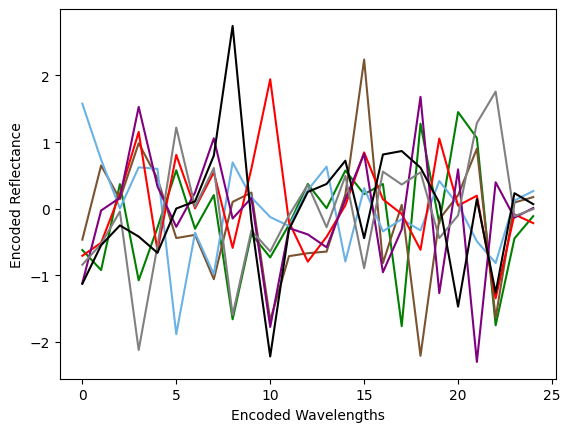

In [52]:
# Per Class Averages in Encoded Space
import numpy as np
import matplotlib.colors as mc

# Calculate mean vector
mean_vec_class1 = np.mean(class_1_signatures, axis=0)
mean_vec_class2 = np.mean(class_2_signatures, axis=0)
mean_vec_class3 = np.mean(class_3_signatures, axis=0)
mean_vec_class4 = np.mean(class_4_signatures, axis=0)
mean_vec_class5 = np.mean(class_5_signatures, axis=0)
mean_vec_class6 = np.mean(class_6_signatures, axis=0)
mean_vec_class7 = np.mean(class_7_signatures, axis=0)

colors=('green',np.array(mc.to_rgb('#7a5331')),np.array(mc.to_rgb('#6ab2e6')),'red','purple','grey','black')
plt.plot(mean_vec_class1, c=colors[0])
plt.plot(mean_vec_class2, c=colors[1])
plt.plot(mean_vec_class3, c=colors[2])
plt.plot(mean_vec_class4, c=colors[3])
plt.plot(mean_vec_class5, c=colors[4])
plt.plot(mean_vec_class6, c=colors[5])
plt.plot(mean_vec_class7, c=colors[6])
# Add labels and title
plt.xlabel("Encoded Wavelengths")
plt.ylabel("Encoded Reflectance")
# Show the plot
plt.show()

In [53]:
# SIDs in Encoded Space
vector_list = [mean_vec_class1, mean_vec_class2, mean_vec_class3,
              mean_vec_class4, mean_vec_class5, mean_vec_class6, mean_vec_class7]

SID=np.zeros([num_classes,num_classes])


for aaa in range(num_classes):
 for bbb in range(num_classes):

     # Min-max normalize
     spectrum_a = (vector_list[aaa] - min(vector_list[aaa])) / (max(vector_list[aaa]) - min(vector_list[aaa]))
     spectrum_b = (vector_list[bbb] - min(vector_list[bbb])) / (max(vector_list[bbb]) - min(vector_list[bbb]))

     # Normalize to probability distributions
     spectrum_a /= np.sum(spectrum_a)
     spectrum_b /= np.sum(spectrum_b)

     # Calculate SID
     SIDab = 0
     SIDba = 0
     for i in range(len(spectrum_a)):
       if spectrum_a[i] != 0 and spectrum_b[i] != 0:
         SIDab += spectrum_a[i] * np.log(spectrum_a[i] / spectrum_b[i])

     for i in range(len(spectrum_b)):
       if spectrum_a[i] != 0 and spectrum_b[i] != 0:
         SIDba += spectrum_b[i] * np.log(spectrum_b[i] / spectrum_a[i])

     SID[aaa,bbb] = SIDab + SIDba
     SID_Scaled = SID * num_channels_t / latent_space_dim

print(SID_Scaled)

[[0.         1.14895304 1.62728065 1.24781313 1.54994011 1.42084397
  1.65001777]
 [1.14895304 0.         0.48730966 1.07102879 0.420936   1.12350595
  0.77569518]
 [1.62728065 0.48730966 0.         1.02425384 0.82580051 1.03804561
  0.77715869]
 [1.24781313 1.07102879 1.02425384 0.         1.19859883 0.73677396
  0.88366725]
 [1.54994011 0.420936   0.82580051 1.19859883 0.         0.51853896
  0.74771805]
 [1.42084397 1.12350595 1.03804561 0.73677396 0.51853896 0.
  0.92816986]
 [1.65001777 0.77569518 0.77715869 0.88366725 0.74771805 0.92816986
  0.        ]]


In [54]:
# Determinant of Scatter Matrices in Encoded Space
import numpy as np

inputs_list = [class_1_signatures, class_2_signatures, class_3_signatures,
              class_4_signatures, class_5_signatures, class_6_signatures, class_7_signatures]

vector_list = [mean_vec_class1, mean_vec_class2, mean_vec_class3,
              mean_vec_class4, mean_vec_class5, mean_vec_class6, mean_vec_class7]

Scatter_dets=np.zeros([num_classes,num_classes])


for aaa in range(num_classes):
 for bbb in range(num_classes):

    # Calculate scatter matrix
    scatter_mat = np.zeros((latent_space_dim , latent_space_dim ))
    min_len = min(inputs_list[aaa].shape[0], inputs_list[bbb].shape[0])
    for i in range(min_len):
        scatter_mat += np.outer(inputs_list[aaa][i]-vector_list[aaa], inputs_list[bbb][i]-vector_list[bbb])

    scatter_mat /= min_len # normalize by number of vectors

    # Calculate determinant
    Scatter_dets[aaa,bbb] = np.linalg.det(scatter_mat)

print(Scatter_dets)

[[ 5.71153867e-16 -4.39721794e-44  6.16827808e-40  1.05270739e-31
   6.52306597e-45  2.04310384e-42  9.54687431e-44]
 [-4.39721794e-44  2.49785536e-14  4.69854674e-37  1.98808441e-31
   1.09834636e-42 -1.84144516e-41  2.19757866e-42]
 [ 6.16827808e-40  4.69854674e-37  1.57340034e-13  3.39176461e-29
   6.47827626e-37  4.89853920e-39  1.87192764e-37]
 [ 1.05270739e-31  1.98808441e-31  3.39176461e-29  6.74435103e-10
  -1.31870123e-31  7.39306577e-30  1.14864397e-30]
 [ 6.52306597e-45  1.09834636e-42  6.47827626e-37 -1.31870123e-31
   2.05165976e-14  4.22951554e-42  9.90858788e-44]
 [ 2.04310384e-42 -1.84144516e-41  4.89853920e-39  7.39306577e-30
   4.22951554e-42  7.40855069e-15 -8.43333983e-45]
 [ 9.54687431e-44  2.19757866e-42  1.87192764e-37  1.14864397e-30
   9.90858788e-44 -8.43333983e-45  2.28976682e-15]]


In [55]:
# LDAs in Encoded Space
for ccc in range(num_classes):
  for ddd in range(ccc+1, num_classes):
    print(f'S{ccc+1}{ddd+1}/S{ccc+1}',abs(Scatter_dets[ccc][ddd]/Scatter_dets[ccc][ccc]))
    print(f'S{ccc+1}{ddd+1}/S{ddd+1}',abs(Scatter_dets[ccc][ddd]/Scatter_dets[ddd][ddd]))

S12/S1 7.698832477248653e-29
S12/S2 1.760397341232488e-30
S13/S1 1.0799678394136581e-24
S13/S3 3.920348770909819e-27
S14/S1 1.8431239747356798e-16
S14/S4 1.5608727675689465e-22
S15/S1 1.142085581716049e-29
S15/S5 3.1794092303871328e-31
S16/S1 3.57715136514496e-27
S16/S6 2.7577645359767877e-28
S17/S1 1.6715065522811795e-28
S17/S7 4.169365303187615e-29
S23/S2 1.881032346065131e-23
S23/S3 2.986237274922123e-24
S24/S2 7.959165443320485e-18
S24/S4 2.947777185369919e-22
S25/S2 4.3971575502487796e-29
S25/S5 5.353452755265779e-29
S26/S2 7.37210485209953e-28
S26/S6 2.485567342496042e-27
S27/S2 8.797861929884163e-29
S27/S7 9.597390645238782e-28
S34/S3 2.1556907883063237e-16
S34/S4 5.029045194090323e-20
S35/S3 4.1173731202644636e-24
S35/S5 3.157578266716293e-23
S36/S3 3.11334571374191e-26
S36/S6 6.612007397067277e-25
S37/S3 1.1897338487646948e-24
S37/S7 8.17518895962689e-23
S45/S4 1.9552677815447908e-22
S45/S5 6.427484985146274e-18
S46/S4 1.0961863839728796e-20
S46/S6 9.979098581460914e-16
S47/S4

**Original Space:**


In [56]:
%cd /content/drive/My\ Drive/GANHDA

# Pavia
import scipy.io
Pavia = scipy.io.loadmat('DataCube-RPaviaU-DPaviaC.mat')
target_data=Pavia['DataCube2']  #DPaviaC
target_gt=Pavia['gt2']  #DPaviaC
del Pavia
gc.collect()

/content/drive/My Drive/GANHDA


3690

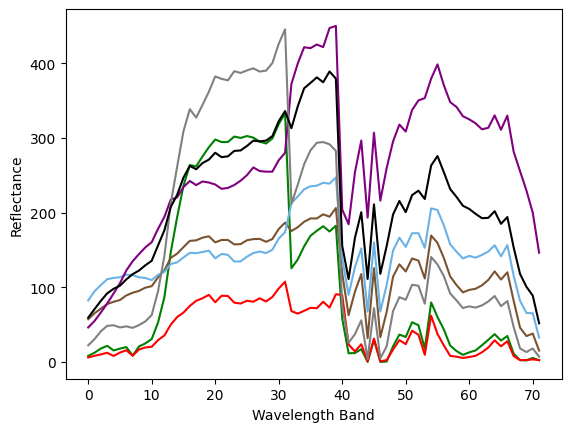

In [57]:
# Per Class Averages in Original Space
import numpy as np
import matplotlib.colors as mc

mean_vec_class1 = np.mean(target_data[target_gt == 1], axis=0)
mean_vec_class2 = np.mean(target_data[target_gt == 2], axis=0)
mean_vec_class3 = np.mean(target_data[target_gt == 3], axis=0)
mean_vec_class4 = np.mean(target_data[target_gt == 4], axis=0)
mean_vec_class5 = np.mean(target_data[target_gt == 5], axis=0)
mean_vec_class6 = np.mean(target_data[target_gt == 6], axis=0)
mean_vec_class7 = np.mean(target_data[target_gt == 7], axis=0)

colors=('green',np.array(mc.to_rgb('#7a5331')),np.array(mc.to_rgb('#6ab2e6')),'red','purple','grey','black')
plt.plot(mean_vec_class1, c=colors[0])
plt.plot(mean_vec_class2, c=colors[1])
plt.plot(mean_vec_class3, c=colors[2])
plt.plot(mean_vec_class4, c=colors[3])
plt.plot(mean_vec_class5, c=colors[4])
plt.plot(mean_vec_class6, c=colors[5])
plt.plot(mean_vec_class7, c=colors[6])
plt.xlabel('Wavelength Band')
plt.ylabel('Reflectance')
# Show the plot
plt.show()

In [58]:
# SIDs in Original Space
vector_list = [mean_vec_class1, mean_vec_class2, mean_vec_class3,
              mean_vec_class4, mean_vec_class5, mean_vec_class6, mean_vec_class7]

SID=np.zeros([num_classes,num_classes])


for aaa in range(num_classes):
 for bbb in range(num_classes):

     # Min-max normalize
     spectrum_a = (vector_list[aaa] - min(vector_list[aaa])) / (max(vector_list[aaa]) - min(vector_list[aaa]))
     spectrum_b = (vector_list[bbb] - min(vector_list[bbb])) / (max(vector_list[bbb]) - min(vector_list[bbb]))


     # Normalize to probability distributions
     spectrum_a /= np.sum(spectrum_a)
     spectrum_b /= np.sum(spectrum_b)

     # Calculate SID
     SIDab = 0
     SIDba = 0
     for i in range(len(spectrum_a)):
       if spectrum_a[i] != 0 and spectrum_b[i] != 0:
         SIDab += spectrum_a[i] * np.log(spectrum_a[i] / spectrum_b[i])

     for i in range(len(spectrum_b)):
       if spectrum_a[i] != 0 and spectrum_b[i] != 0:
         SIDba += spectrum_b[i] * np.log(spectrum_b[i] / spectrum_a[i])

     SID[aaa,bbb] = SIDab + SIDba

print(SID)


[[0.         0.68463932 1.05509072 0.16460303 1.37087341 0.0847322
  0.67551934]
 [0.68463932 0.         0.04719115 0.30998133 0.21135164 0.30919628
  0.06764096]
 [1.05509072 0.04719115 0.         0.54873744 0.12031933 0.55598736
  0.10358439]
 [0.16460303 0.30998133 0.54873744 0.         0.81590183 0.11363754
  0.34775026]
 [1.37087341 0.21135164 0.12031933 0.81590183 0.         0.77698405
  0.12309156]
 [0.0847322  0.30919628 0.55598736 0.11363754 0.77698405 0.
  0.28482013]
 [0.67551934 0.06764096 0.10358439 0.34775026 0.12309156 0.28482013
  0.        ]]


In [59]:
# Determinant of Scatter Matrices in Original Space
import numpy as np

Scatter_dets=np.zeros([num_classes,num_classes])
vector_list = [mean_vec_class1, mean_vec_class2, mean_vec_class3,
              mean_vec_class4, mean_vec_class5, mean_vec_class6, mean_vec_class7]



for aaa in range(num_classes):
 for bbb in range(num_classes):

    # Extract indices where target_gt == aaa
    class_aaa_inds = np.where(target_gt == aaa)
    # Use advanced indexing to extract class aaa spectra
    class_aaa_data = target_data[class_aaa_inds[0],class_aaa_inds[1],:]

    # Extract indices where target_gt == bbb
    class_bbb_inds = np.where(target_gt == bbb)
    # Use advanced indexing to extract class bbb spectra
    class_bbb_data = target_data[class_bbb_inds[0],class_bbb_inds[1],:]

    # Calculate scatter matrix
    scatter_mat = np.zeros((num_channels_t , num_channels_t ))
    min_len = min(class_aaa_data.shape[0], class_bbb_data.shape[0])
    for i in range(min_len):
        scatter_mat += np.outer(class_aaa_data[i]-vector_list[aaa], class_bbb_data[i]-vector_list[bbb])

    scatter_mat /= min_len # normalize by number of vectors

    # Calculate determinant
    Scatter_dets[aaa,bbb] = np.linalg.det(scatter_mat)

print(Scatter_dets)

[[ 4.27983833e+111 -7.99730263e+032 -6.64728235e+038 -7.24017562e+049
   9.31963627e+051 -2.41281221e+038 -1.96596235e+046]
 [-7.99730263e+032  1.07658785e+090  2.57780677e+033 -6.22211618e+041
   8.17285347e+012  4.28120703e+032  1.78550919e+037]
 [-6.64728235e+038  2.57780677e+033  2.32433528e+094  4.88470983e+045
  -9.62598967e+051 -1.55576713e+038  5.82632016e+039]
 [-7.24017562e+049 -6.22211618e+041  4.88470983e+045  4.80634204e+089
   3.15702787e+049 -8.69604247e+048 -3.18870508e+044]
 [ 9.31963626e+051  1.13734795e+013 -9.62598967e+051  3.15702787e+049
   6.94924545e+077  6.92258935e+055  1.70090935e+051]
 [-2.41281225e+038  4.28120703e+032 -1.55576713e+038 -8.69604247e+048
   6.92258939e+055  4.85857472e+103  2.84217244e+044]
 [-1.96596235e+046  1.78550919e+037  5.82632016e+039 -3.18870508e+044
   1.70090935e+051  2.84217244e+044  4.20296350e+094]]


In [60]:
#LDAs in Original Space
for ccc in range(num_classes):
  for ddd in range(ccc+1, num_classes):
    print(f'S{ccc+1}{ddd+1}/S{ccc+1}',abs(Scatter_dets[ccc][ddd]/Scatter_dets[ccc][ccc]))
    print(f'S{ccc+1}{ddd+1}/S{ddd+1}',abs(Scatter_dets[ccc][ddd]/Scatter_dets[ddd][ddd]))

S12/S1 1.8685992359786468e-79
S12/S2 7.428379079705147e-58
S13/S1 1.553162021725802e-73
S13/S3 2.859863811506844e-56
S14/S1 1.6916937197486772e-62
S14/S4 1.5063796059509329e-40
S15/S1 2.1775673631849073e-60
S15/S5 1.3411004593553594e-26
S16/S1 5.6376246472094575e-74
S16/S6 4.966090558063278e-66
S17/S1 4.593543492321459e-66
S17/S7 4.677562277236458e-49
S23/S2 2.3944230690661954e-57
S23/S3 1.1090511754987854e-61
S24/S2 5.779478377822406e-49
S24/S4 1.2945637513941923e-48
S25/S2 7.591441331119377e-78
S25/S5 1.1760778243737154e-65
S26/S2 3.9766443983033015e-58
S26/S6 8.811652124378187e-72
S27/S2 1.6584890837647008e-53
S27/S7 4.248214840594143e-58
S34/S3 2.101551299963786e-49
S34/S4 1.0163050801106977e-44
S35/S3 4.1413946387371046e-43
S35/S5 1.3851848714740662e-26
S36/S3 6.693385163439672e-57
S36/S6 3.202106001640655e-66
S37/S3 2.5066608100871855e-55
S37/S7 1.3862409605478653e-55
S45/S4 6.568462769834827e-41
S45/S5 4.542979371280676e-29
S46/S4 1.8092849834573643e-41
S46/S6 1.7898340501625745